# Batch RL Prompt Optimization with Generalization

This notebook implements a Batch Reinforcement Learning loop to optimize Text-to-SQL prompts.
Features:
- **Dataset**: 'challenging' difficulty only.
- **Split**: 80% Train / 20% Test.
- **Batch Processing**: Processes 10 questions at a time.
- **Generalization**: Optimizes the prompt based on the aggregate performance of the entire batch, avoiding overfitting to single examples.
- **GRPO-like Sampling**: Generates 8 candidate SQLs per question.
- **Reward**: Composite score (Execution Match + String Similarity + Validity).
- **Pure RL**: Optimization relies ONLY on reward scores and execution results, not ground truth SQL.
- **Single Pass**: Optimization runs once per batch to speed up training.

In [4]:
import sqlite3
import csv
import os
import pandas as pd
import random
import difflib
from typing import Annotated, TypedDict, List, Dict, Any
from datasets import load_dataset
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, END
import json
import numpy as np

# ----------------------------------------
# 1. Configuration & Setup
# ----------------------------------------
DB_ROOT = "/home/pj/NLP Project/dev_databases"
MODEL_NAME = "Qwen/Qwen3-Next-80B-A3B-Instruct"
BASE_URL = "http://211.47.56.81:7972/v1"
API_KEY = "token-abc123"
BATCH_SIZE = 10

# LLM for Generation (Temperature > 0 for diversity)
llm_gen = ChatOpenAI(
    model=MODEL_NAME,
    openai_api_base=BASE_URL,
    openai_api_key=API_KEY,
    temperature=0.7
)

# LLM for Optimization (Temperature 0 for stability)
llm_opt = ChatOpenAI(
    model=MODEL_NAME,
    openai_api_base=BASE_URL,
    openai_api_key=API_KEY,
    temperature=0.0
)

# ----------------------------------------
# 2. Load Dataset & Split
# ----------------------------------------
dataset = load_dataset("birdsql/bird_sql_dev_20251106")["dev_20251106"]

# Filter for 'challenging'
challenging_ds = dataset.filter(lambda x: x["difficulty"] == "challenging")

# Shuffle and Split 80/20
full_list = list(challenging_ds)
random.seed(42)
random.shuffle(full_list)

split_idx = int(len(full_list) * 0.8)
train_samples = full_list[:split_idx]
test_samples = full_list[split_idx:]

print(f"Total Challenging: {len(full_list)}")
print(f"Train Size: {len(train_samples)}")
print(f"Test Size: {len(test_samples)}")

/home/pj/NLP Project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Total Challenging: 231
Train Size: 184
Test Size: 47


In [6]:
test_samples[2]

{'question_id': 191,
 'db_id': 'financial',
 'question': 'What are the statistics for the top 50 highest loan amounts among 24-month loans with weekly statement issuance that have an owner, including total count, average loan amount, payment details, interest rates, loan status distribution, and district economic indicators?',
 'evidence': "Weekly statement issuance refers to frequency = 'POPLATEK TYDNE'. Loan status: A = contract finished no problems, B = contract finished loan not paid, C = running contract OK so far, D = running contract client in debt.",
 'SQL': "WITH LoanAccountStats AS (\n    SELECT \n        a.account_id,\n        a.district_id,\n        a.frequency,\n        l.duration,\n        l.amount,\n        l.payments,\n        l.status,\n        d.A2 AS district_name,\n        d.A3 AS region,\n        d.A11 AS avg_salary,\n        d.A12 AS unemployment_rate_1995,\n        ROUND(l.amount / l.duration, 2) AS monthly_principal,\n        ROUND(l.payments - (l.amount / l.dur

In [2]:
# ----------------------------------------
# 3. Helper Functions
# ----------------------------------------
def execute_sql(db_path, sql):
    try:
        conn = sqlite3.connect(db_path)
        cur = conn.cursor()
        cur.execute(sql)
        result = cur.fetchall()
        conn.close()
        return result
    except Exception as e:
        return f"ERROR: {e}"

def load_schema_from_csv(db_dir):
    schema = {"tables": {}}
    schema_csv_dir = os.path.join(db_dir, "database_description")
    if not os.path.exists(schema_csv_dir):
        return schema

    for file in os.listdir(schema_csv_dir):
        if file.endswith(".csv"):
            table_name = file.replace(".csv", "")
            csv_path = os.path.join(schema_csv_dir, file)
            
            # Try different encodings to handle UnicodeDecodeError
            df = None
            for encoding in ["utf-8", "cp1252", "latin1"]:
                try:
                    df = pd.read_csv(csv_path, sep=None, engine="python", encoding=encoding)
                    break
                except UnicodeDecodeError:
                    continue
            
            if df is None:
                print(f"[WARNING] Could not decode {csv_path}. Skipping.")
                continue

            cols = ["original_column_name", "column_description", "data_format", "value_description"]
            for c in cols:
                if c not in df.columns:
                    df[c] = ""
            records = df[cols].to_dict(orient="records")
            schema["tables"][table_name] = records
    return schema

def format_schema(schema):
    return json.dumps(schema, indent=2)

def calculate_similarity(s1, s2):
    return difflib.SequenceMatcher(None, s1, s2).ratio()

In [3]:
# ----------------------------------------
# 4. Define State (Batch)
# ----------------------------------------
class BatchState(TypedDict):
    # Batch Inputs
    questions: List[str]
    db_ids: List[str]
    gold_sqls: List[str]
    schemas: List[str]
    gold_results: List[str]
    
    current_prompt: str
    
    # Batch Outputs (List of Lists)
    # generated_sqls[i] = List of 8 candidates for question i
    generated_sqls: List[List[str]]
    execution_results: List[List[str]]
    rewards: List[List[float]]
    
    # Summary stats for the batch
    batch_success_count: int
    batch_avg_reward: float
    
    iterations: int

In [4]:
# ----------------------------------------
# 5. Define Nodes
# ----------------------------------------

def generate_sql_batch_node(state: BatchState):
    print(f"--- Generating SQLs for Batch (Iter {state['iterations']}) ---")
    prompt_template = state['current_prompt']
    
    all_candidates = []
    
    for i, question in enumerate(state['questions']):
        schema = state['schemas'][i]
        full_prompt = f"""{prompt_template}

### Schema
{schema}

### Question
{question}

Return only the SQL query.
"""
        candidates = []
        # Generate 8 candidates
        for _ in range(8):
            response = llm_gen.invoke([HumanMessage(content=full_prompt)])
            sql = response.content.strip().replace("```sql", "").replace("```", "").strip()
            candidates.append(sql)
        all_candidates.append(candidates)
        
    return {"generated_sqls": all_candidates}

def evaluate_sql_batch_node(state: BatchState):
    print("--- Evaluating Batch ---")
    
    all_rewards = []
    all_exec_results = []
    success_count = 0
    
    for i, candidates in enumerate(state['generated_sqls']):
        db_id = state['db_ids'][i]
        gold_sql = state['gold_sqls'][i]
        gold_res = state['gold_results'][i]
        
        db_dir = f"{DB_ROOT}/{db_id}"
        db_path = f"{db_dir}/{db_id}.sqlite"
        
        cand_rewards = []
        cand_results = []
        
        for pred_sql in candidates:
            pred_res = execute_sql(db_path, pred_sql)
            cand_results.append(str(pred_res))
            
            # Reward Calc
            r_exec = 1.0 if str(pred_res) == str(gold_res) else 0.0
            r_sim = calculate_similarity(pred_sql, gold_sql)
            r_valid = 0.1 if "ERROR" not in str(pred_res) else 0.0
            
            total_reward = (2.0 * r_exec) + (0.5 * r_sim) + r_valid
            cand_rewards.append(total_reward)
            
        all_rewards.append(cand_rewards)
        all_exec_results.append(cand_results)
        
        # Check if any candidate in this group succeeded (Exec Match)
        if any(r >= 2.0 for r in cand_rewards):
            success_count += 1

    avg_reward = np.mean([max(r) for r in all_rewards])
    print(f"Batch Success: {success_count}/{len(state['questions'])} | Avg Max Reward: {avg_reward:.4f}")
    
    return {
        "execution_results": all_exec_results,
        "rewards": all_rewards,
        "batch_success_count": success_count,
        "batch_avg_reward": avg_reward
    }

def optimize_prompt_batch_node(state: BatchState):
    print("--- Optimizing Prompt (Generalization) ---")
    
    # If batch performance is very high, maybe skip? But let's optimize to generalize.
    if state['batch_success_count'] == len(state['questions']) and state['batch_avg_reward'] > 2.5:
        return {"iterations": state['iterations']  + 1}

    # Construct Feedback Summary
    feedback_text = ""
    for i in range(len(state['questions'])):
        rewards = state['rewards'][i]
        max_r = max(rewards)
        best_idx = rewards.index(max_r)
        
        # Only include failures or "close calls" to save tokens, or include a mix.
        # Let's include everything but briefly.
        status = "SUCCESS" if max_r >= 2.0 else "FAILURE"
        feedback_text += f"Q{i+1} [{status} | Reward: {max_r:.2f}]: {state['questions'][i]}\n"
        feedback_text += f"Best SQL: {state['generated_sqls'][i][best_idx]}\n"
        feedback_text += f"Result: {state['execution_results'][i][best_idx]}\n"
        # REMOVED: Gold SQL and Gold Result to ensure Pure RL
        feedback_text += "---\n"

    optimizer_prompt = f"""
You are an expert Prompt Engineer optimizing a Text-to-SQL prompt.
We tested the current prompt on a batch of {len(state['questions'])} questions.
Here are the results (Question, Best Generated SQL, Execution Result, and Reward Score):

{feedback_text}

Current Prompt:
{state['current_prompt']}

Analyze the results.
- High Reward (>= 2.0): The SQL was correct and executed perfectly.
- Low Reward: The SQL was incorrect, produced an error, or returned the wrong result.

Your goal is to improve the prompt to fix the failures and increase the reward scores.
You do NOT have access to the ground truth SQL. You must infer the correct logic based on the question and the nature of the failure (e.g., "Error: no such column" means the column name was wrong).
Generate a NEW, GENERALIZED prompt that fixes these errors while maintaining performance on the successful cases.
Do not overfit to a specific question; make the instructions robust and applicable to any schema.
Return ONLY the new prompt text.
"""
    response = llm_opt.invoke([HumanMessage(content=optimizer_prompt)])
    new_prompt = response.content.strip()
    return {"current_prompt": new_prompt, "iterations": state['iterations'] + 1}

def should_continue(state: BatchState):
    # Stop if perfect batch
    if state['batch_success_count'] == len(state['questions']) and state['batch_avg_reward'] > 2.5:
        return END
    # Always optimize once then stop (Single Pass)
    return "optimize_prompt"

In [5]:
# ----------------------------------------
# 6. Build Graph
# ----------------------------------------
workflow = StateGraph(BatchState)

workflow.add_node("generate_sql", generate_sql_batch_node)
workflow.add_node("evaluate_sql", evaluate_sql_batch_node)
workflow.add_node("optimize_prompt", optimize_prompt_batch_node)

workflow.set_entry_point("generate_sql")
workflow.add_edge("generate_sql", "evaluate_sql")
workflow.add_conditional_edges(
    "evaluate_sql",
    should_continue,
    {
        "optimize_prompt": "optimize_prompt",
        END: END
    }
)
# Changed edge: Optimize -> END (No loop back)
workflow.add_edge("optimize_prompt", END)

app = workflow.compile()

Starting training on 184 samples (19 batches)...

========== Batch 1/19 (Samples 0-10) ==========
--- Generating SQLs for Batch (Iter 0) ---
--- Evaluating Batch ---
Batch Success: 0/10 | Avg Max Reward: 0.1746
--- Optimizing Prompt (Generalization) ---
Batch Final Avg Reward: 0.1746
Optimized Prompt (End of Batch):
You are a Text-to-SQL model. Given a database schema and a natural language question, generate a valid SQLite SQL query that correctly answers the question.

Before writing the query:
1. Carefully exa...

========== Batch 2/19 (Samples 10-20) ==========
--- Generating SQLs for Batch (Iter 0) ---
--- Evaluating Batch ---
Batch Success: 1/10 | Avg Max Reward: 0.4374
--- Optimizing Prompt (Generalization) ---
Batch Final Avg Reward: 0.4374
Optimized Prompt (End of Batch):
You are a Text-to-SQL model. Given a database schema and a natural language question, generate a valid SQLite SQL query that correctly answers the question.

Before writing the query:
1. Carefully exa...

===

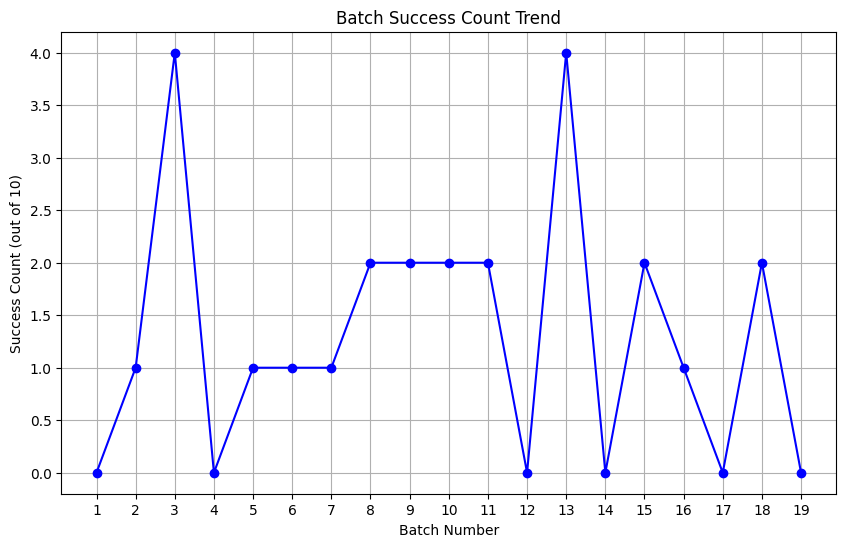

In [7]:
# ----------------------------------------
# 7. Run Batch Training Loop
# ----------------------------------------
import time
import matplotlib.pyplot as plt
import tiktoken

initial_prompt = """
You are a Text-to-SQL model.
Given the database schema and a natural language question,
generate a valid SQLite SQL query.
"""

# Process in batches
# Run on ALL training samples
import math
num_batches = math.ceil(len(train_samples) / BATCH_SIZE)

print(f"Starting training on {len(train_samples)} samples ({num_batches} batches)...")

# 기록 리스트 초기화
batch_success_list = []   # 각 배치 맞춘 문제 수
batch_size_list = []      # 각 배치 문제 총 개수
batch_avg_reward_list = []  # 평균 reward 기록(선택 옵션)

start_time = time.time()

for b in range(num_batches):
    start_idx = b * BATCH_SIZE
    end_idx = start_idx + BATCH_SIZE
    batch_samples = train_samples[start_idx:end_idx]
    
    if not batch_samples:
        break
        
    print(f"\n========== Batch {b+1}/{num_batches} (Samples {start_idx}-{end_idx}) ==========")
    
    # Prepare Batch Inputs
    questions = []
    db_ids = []
    gold_sqls = []
    schemas = []
    gold_results = []
    
    for s in batch_samples:
        questions.append(s['question'])
        db_ids.append(s['db_id'])
        gold_sqls.append(s['SQL'])
        
        db_dir = f"{DB_ROOT}/{s['db_id']}"
        db_path = f"{db_dir}/{s['db_id']}.sqlite"
        
        # Pre-calc gold result
        g_res = execute_sql(db_path, s['SQL'])
        gold_results.append(str(g_res))
        
        sch = load_schema_from_csv(db_dir)
        schemas.append(format_schema(sch))

    inputs = {
        "questions": questions,
        "db_ids": db_ids,
        "gold_sqls": gold_sqls,
        "schemas": schemas,
        "gold_results": gold_results,
        "current_prompt": initial_prompt,
        "generated_sqls": [],
        "execution_results": [],
        "rewards": [],
        "batch_success_count": 0,
        "batch_avg_reward": 0.0,
        "iterations": 0
    }
    
    # 실제 Batch training 실행
    final_state = app.invoke(inputs)
    
    # 결과 출력
    print(f"Batch Final Avg Reward: {final_state['batch_avg_reward']:.4f}")
    print(f"Optimized Prompt (End of Batch):\n{final_state['current_prompt'][:200]}...")
    
    # ==== 기록 추가 ====
    batch_success_list.append(final_state['batch_success_count'])
    batch_size_list.append(len(batch_samples))
    batch_avg_reward_list.append(final_state['batch_avg_reward'])

    # 업데이트된 프롬프트를 다음 batch에 전달
    initial_prompt = final_state['current_prompt']

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTotal Optimization Time: {elapsed_time:.2f} seconds")

# Token Count Calculation
try:
    encoding = tiktoken.get_encoding("cl100k_base")
    token_count = len(encoding.encode(initial_prompt))
    print(f"Final Prompt Token Count: {token_count}")
except Exception as e:
    print(f"Could not calculate token count: {e}")

# Plotting the trend
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(batch_success_list) + 1), batch_success_list, marker='o', linestyle='-', color='b')
plt.title('Batch Success Count Trend')
plt.xlabel('Batch Number')
plt.ylabel('Success Count (out of 10)')
plt.grid(True)
plt.xticks(range(1, len(batch_success_list) + 1))
plt.show()

In [8]:
# ----------------------------------------
# 8. Final Test Set Evaluation
# ----------------------------------------
print("\n========== Final Test Set Evaluation ==========")
print(f"Evaluating on {len(test_samples)} test samples...")

correct_count = 0

for i, sample in enumerate(test_samples):
    db_dir = f"{DB_ROOT}/{sample['db_id']}"
    db_path = f"{db_dir}/{sample['db_id']}.sqlite"
    
    schema = load_schema_from_csv(db_dir)
    schema_text = format_schema(schema)
    
    # Generate SQL using Final Prompt (Single shot, greedy)
    full_prompt = f"""{initial_prompt}

### Schema
{schema_text}

### Question
{sample['question']}

Return only the SQL query.
"""
    # Use temperature 0 for evaluation
    response = llm_opt.invoke([HumanMessage(content=full_prompt)])
    pred_sql = response.content.strip().replace("```sql", "").replace("```", "").strip()
    
    # Execute
    pred_res = execute_sql(db_path, pred_sql)
    gold_res = execute_sql(db_path, sample['SQL'])
    
    if str(pred_res) == str(gold_res):
        correct_count += 1
        
    if (i+1) % 10 == 0:
        print(f"Processed {i+1}/{len(test_samples)}...")

accuracy = correct_count / len(test_samples)
print(f"\nFinal Test Accuracy: {accuracy*100:.2f}% ({correct_count}/{len(test_samples)})")
print("Final Prompt Used:")
print(initial_prompt)


========== Final Test Set Evaluation ==========
Evaluating on 47 test samples...
Processed 10/47...
Processed 20/47...
Processed 30/47...
Processed 40/47...

Final Test Accuracy: 14.89% (7/47)
Final Prompt Used:
You are a Text-to-SQL model. Given a database schema and a natural language question, generate a valid SQLite SQL query that correctly answers the question.

Before writing the query:
1. **Never assume column names.** Every table and column name must be used *exactly* as it appears in the schema — including case, spacing, Unicode characters, trailing/leading whitespace, punctuation, and special symbols. Always enclose any identifier containing non-alphanumeric characters (including spaces, hyphens, apostrophes, or Unicode) in double quotes (`"`). Never use backticks, square brackets, or unquoted identifiers. If a column name in the question appears corrupted (e.g., `"F\uff1afemale \nM\uff1amale "`, `"School Name "`, `"the date when the credit card issued "`) or contains invisi

In [9]:
prompt = """You are a Text-to-SQL model.
Given the database schema and a natural language question,
generate a valid SQLite SQL query."""

In [10]:
# ----------------------------------------
# 8. Final Test Set Evaluation
# ----------------------------------------
print("\n========== Final Test Set Evaluation ==========")
print(f"Evaluating on {len(test_samples)} test samples...")

correct_count = 0

for i, sample in enumerate(test_samples):
    db_dir = f"{DB_ROOT}/{sample['db_id']}"
    db_path = f"{db_dir}/{sample['db_id']}.sqlite"
    
    schema = load_schema_from_csv(db_dir)
    schema_text = format_schema(schema)

    # Generate SQL using Final Prompt (Single shot, greedy)
    full_prompt = f"""{prompt}
    

### Schema
{schema_text}

### Question
{sample['question']}

Return only the SQL query.
"""
    # Use temperature 0 for evaluation
    response = llm_opt.invoke([HumanMessage(content=prompt)])
    pred_sql = response.content.strip().replace("```sql", "").replace("```", "").strip()
    
    # Execute
    pred_res = execute_sql(db_path, pred_sql)
    gold_res = execute_sql(db_path, sample['SQL'])
    
    if str(pred_res) == str(gold_res):
        correct_count += 1
        
    if (i+1) % 10 == 0:
        print(f"Processed {i+1}/{len(test_samples)}...")

accuracy = correct_count / len(test_samples)
print(f"\nFinal Test Accuracy: {accuracy*100:.2f}% ({correct_count}/{len(test_samples)})")
print("Final Prompt Used:")
print(prompt)


========== Final Test Set Evaluation ==========
Evaluating on 47 test samples...
Processed 10/47...
Processed 20/47...
Processed 30/47...
Processed 40/47...

Final Test Accuracy: 0.00% (0/47)
Final Prompt Used:
You are a Text-to-SQL model.
Given the database schema and a natural language question,
generate a valid SQLite SQL query.
